In [2]:
import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing

from lib import plotting
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler


In [3]:
%matplotlib inline
matplotlib.style.use('ggplot')
env = gym.envs.make("MountainCar-v0")

In [4]:
def setup_scaler():
    # Feature Preprocessing: Normalize to zero mean and unit variance
    # We use a few samples from the observation space to do this
    observation_examples = np.array([env.observation_space.sample() for _ in range(10000)])
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(observation_examples)

    # Used to convert a state to a featurized representation.
    # We use RBF kernels with different variances to cover different parts of the space
    featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
    ])
    featurizer.fit(scaler.transform(observation_examples))

    def featurize_state(state):
        """
        Returns the featurized representation for a state.
        """
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return [featurized[0]]
    return featurize_state


feature_state_fn = setup_scaler()


In [5]:
class Estimator:
    """
    Value Function approximator. 
    """
    def __init__(self, initial_state):
        self.models = []
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            model.partial_fit(feature_state_fn(initial_state), [0])
            self.models.append(model)
    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
            
        """
        features = feature_state_fn(s)
        if not a:
            return np.array([m.predict(features)[0] for m in self.models])
        else:
            return self.models[a].predict(features)[0]
    
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        features = feature_state_fn(s)
        self.models[a].partial_fit(features, [y])


In [6]:
def make_epsilon_greedy_policy(estimator, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation, epsilon=None):
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        selected_action = best_action
        
        if epsilon is not None:
            action_probs = np.ones(nA, dtype=float) * epsilon / nA
            action_probs[selected_action] += (1.0 - epsilon)
            selected_action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        return selected_action
    
    return policy_fn


In [7]:
def q_learning(env, estimator, policy_fn, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm for fff-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    for i_episode in range(num_episodes):
        
        curr_epsilon = epsilon * epsilon_decay**i_episode
        last_reward = stats.episode_rewards[i_episode - 1]
        sys.stdout.flush()
        
        state = env.reset()
        
        for t in itertools.count():
                           
            action = policy_fn(state, curr_epsilon)

            next_state, reward, done, _ = env.step(action)
            
            # TD Update
            q_values_next = estimator.predict(next_state)
            td_target = reward + discount_factor * np.max(q_values_next)
        
            estimator.update(state, action, td_target)
            
            state = next_state

            print("\rStep {} @ Episode {}/{} ({})".format(t, i_episode + 1, num_episodes, last_reward), end="")

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            if done:
                break
                           
    return stats


In [8]:
estimator = Estimator(env.reset())
policy = make_epsilon_greedy_policy(estimator, env.action_space.n) 
stats = q_learning(env, estimator,policy, 180, epsilon=0.0)


Step 141 @ Episode 180/180 (-113.0)

In [12]:

policy_fn = make_epsilon_greedy_policy(estimator, env.action_space.n) 
observation = env.reset()
for t in range(100):
    env.render()
    action = policy_fn(observation)
    observation, reward, done, info = env.step(action)
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break


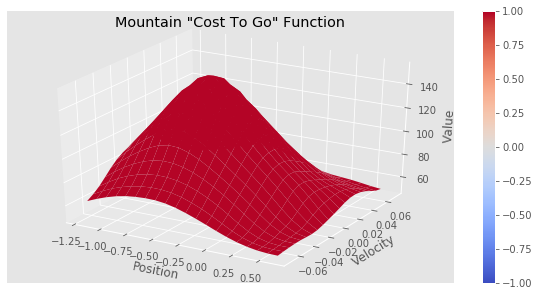

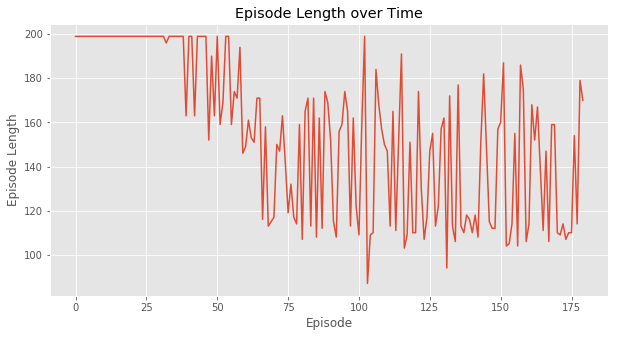

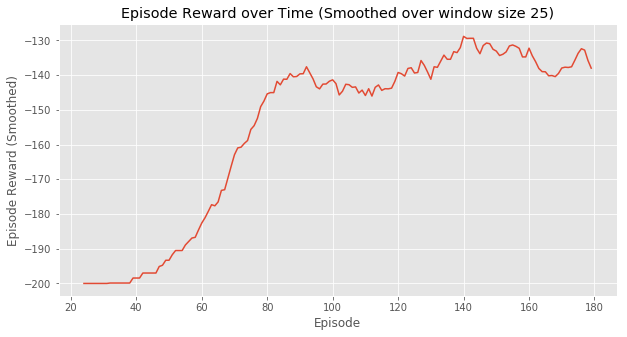

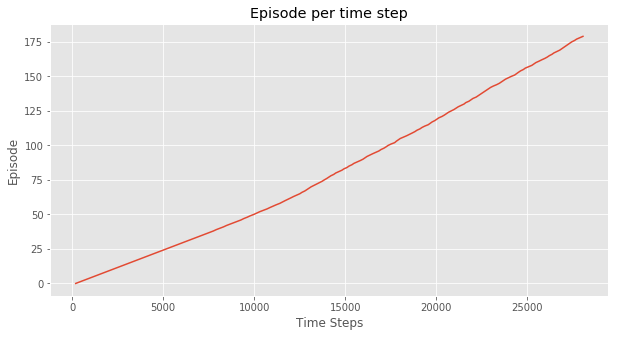

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [13]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)


In [ ]:
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('Breakout-v0')
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for _ in range(100):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = policy_fn(observation)
    state = env.step(action)